<a href="https://colab.research.google.com/github/khalil649/Machine-Learning/blob/main/notebooks/05.00-Machine-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

**Flight Delay Prediction Dataset**


Training Logistic Regression...
Accuracy: 0.9551640759930915
Precision: 0.9576086956521739
Recall: 0.9065651368594361
F1 Score: 0.9313880959932339
ROC AUC: 0.98956819840295
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      9616
           1       0.96      0.91      0.93      4859

    accuracy                           0.96     14475
   macro avg       0.96      0.94      0.95     14475
weighted avg       0.96      0.96      0.95     14475



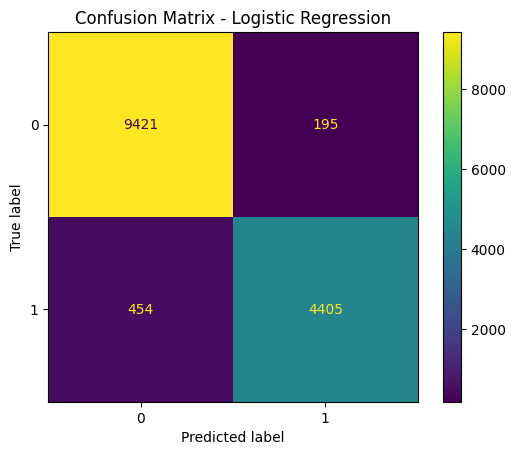


Training Random Forest...
Accuracy: 0.9932297063903281
Precision: 0.9812007277137659
Recall: 0.998970981683474
F1 Score: 0.990006118702835
ROC AUC: 0.9997455063061188
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9616
           1       0.98      1.00      0.99      4859

    accuracy                           0.99     14475
   macro avg       0.99      0.99      0.99     14475
weighted avg       0.99      0.99      0.99     14475



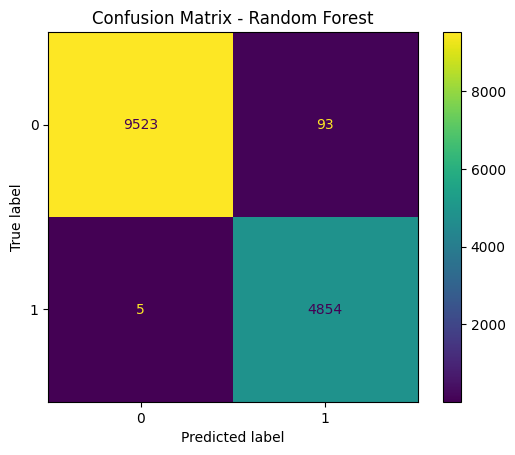


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9985492227979275
Precision: 0.9975318798848211
Recall: 0.9981477670302531
F1 Score: 0.9978397284230017
ROC AUC: 0.9999900051673498
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9616
           1       1.00      1.00      1.00      4859

    accuracy                           1.00     14475
   macro avg       1.00      1.00      1.00     14475
weighted avg       1.00      1.00      1.00     14475



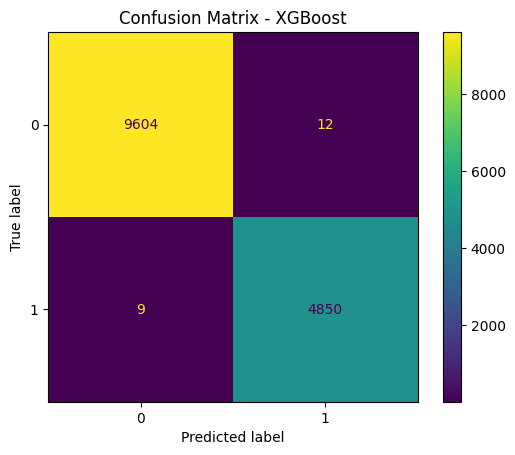

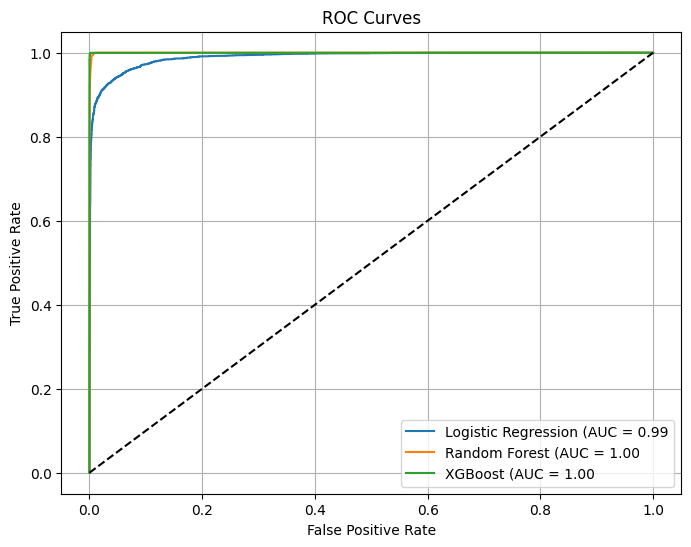

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import dask.dataframe as dd

#model = RandomForestClassifier(n_jobs=-1)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve
)

# Load data with low_memory=False
df = pd.read_csv('data/flights_delay.csv', low_memory=False)
#df = dd.read_csv('flights_delay.csv')

# Convert known problematic columns to string to avoid int/str mix
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].astype(str)
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].astype(str)

# Create target variable
df['ARR_DEL15'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if pd.notna(x) and x > 15 else 0)

# Drop irrelevant or redundant columns
df.drop(columns=[
    'FLIGHT_NUMBER', 'TAIL_NUMBER', 'YEAR', 'CANCELLED', 'CANCELLATION_REASON',
    'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME'
], inplace=True)

# Feature selection
features = [
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DEPARTURE_DELAY', 'DISTANCE', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
    'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]
X = df[features]
y = df['ARR_DEL15']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Clean numeric features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

model = RandomForestClassifier(n_jobs=-1)

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Build full pipeline
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train
    full_pipeline.fit(X_train, y_train)

    # Predict
    y_pred = full_pipeline.predict(X_test)
    y_proba = full_pipeline.predict_proba(X_test)[:, 1]

    # Evaluate
    results[name] = {
        'pipeline': full_pipeline,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'report': classification_report(y_test, y_pred),
        'proba': y_proba
    }

    print("Accuracy:", results[name]['accuracy'])
    print("Precision:", results[name]['precision'])
    print("Recall:", results[name]['recall'])
    print("F1 Score:", results[name]['f1'])
    print("ROC AUC:", results[name]['roc_auc'])
    print("Classification Report:\n", results[name]['report'])

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.savefig(f"figures/confusion_matrix_{name.replace(' ', '_')}.png")
    plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for name in models:
    fpr, tpr, _ = roc_curve(y_test, results[name]['proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('figures/flight_roc_curve.png')
plt.show()
